In [1]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random
import sys
import pickle
import os
from scipy.io import loadmat
# Load the MNIST digit data
M = loadmat("mnist_all.mat")

In [2]:
def softmax(y):
    '''Return the output of the softmax function for the matrix of output y. y
    is an NxM matrix where N is the number of outputs for a single case, and M
    is the number of cases'''
    return exp(y) / tile(sum(exp(y), 0), (len(y), 1))

In [3]:
def tanh_layer(y, W, b):
    '''Return the output of a tanh layer for the input matrix y. y
    is an NxM matrix where N is the number of inputs for a single case, and M
    is the number of cases'''
    return tanh(dot(W.T, y) + b)

In [4]:
def forward(x, W0, b0, W1, b1):
    L0 = tanh_layer(x, W0, b0)
    L1 = dot(W1.T, L0) + b1
    output = softmax(L1)
    return L0, L1, output

In [5]:
def cost_function(y, p):
    return -np.sum(y * np.log(p))

In [6]:
def get_data(M):
    train_keys = [key for key in M.keys() if "train" in key]
    data_length = 0
    for train_k in train_keys:
        data_length += M[train_k].shape[0]

    # concatenate all the data
    train_data = np.zeros((data_length, 784))
    data_counter = 0
    data_size = 0

    train_y = np.zeros((data_length, 10))
    for i, train_k in enumerate(train_keys):
        data_size = M[train_k].shape[0]
        #print(i, data_size)
        train_data[data_counter: data_counter + data_size, :] = M[train_k]
        train_y[data_counter: data_counter + data_size, i] = 1
        data_counter += data_size
    return train_data, train_y

#plot learning curves
#collect testing data
def get_test_data(M):
    train_keys = [key for key in M.keys() if "test" in key]
    data_length = 0
    for train_k in train_keys:
        data_length += M[train_k].shape[0]

    # concatenate all the data
    train_data = np.zeros((data_length, 784))
    print(data_length)
    data_counter = 0
    data_size = 0

    train_y = np.zeros((data_length, 10))
    for i, train_k in enumerate(train_keys):
        data_size = M[train_k].shape[0]
        #print(i, data_size)
        train_data[data_counter: data_counter + data_size, :] = M[train_k]
        train_y[data_counter: data_counter + data_size, i] = 1
        data_counter += data_size
    return train_data, train_y

In [7]:
def part2(x, W0, b0):
    total_W0 = np.concatenate((b0, W0))
    added_ones = np.ones(x.shape[1]).reshape(x.shape[1], 1)
    total_x = np.concatenate((added_ones.T, x))
    vals = softmax(np.dot(total_W0.T, total_x))
    return vals.T

def part3(x, y1, p):
    deriv = np.subtract(p, y1)
    added_ones = np.ones(x.shape[1]).reshape(x.shape[1], 1)
    total_x = np.concatenate((added_ones.T, x))
    deriv = np.matmul(deriv.T, total_x.T).T
    return deriv  # shape 10, 785

In [8]:
def df(x, W0, y):
    # this W0 is assumed to have the bias incorperated into it
    #print(W0.shape, y.shape)
    W1, b0 = W0[:-1, :].reshape(784, W0.shape[1]), W0[-1, :].reshape(1, 10)
    vals = part2(x, W1, b0)
    return part3(x, y, vals)

In [9]:
# PART ONE DATA SNIPPIT
# Load sample weights for the multilayer neural network
snapshot = pickle.load(open("snapshot50.pkl", "rb"), encoding="latin-1")
W0 = snapshot["W0"]  # data
b0 = snapshot["b0"].reshape((300, 1))  # bias?
W1 = snapshot["W1"]  # should be likelihoods?
b1 = snapshot["b1"].reshape((10, 1))  # classes?
#print(W0.shape)

np.random.seed(0)
weights = np.random.random(size=784*10).reshape((784, 10))/10.
weights_bias = np.zeros(10).reshape(1, 10)
#np.random.random(size=10).reshape((1, 10))



In [13]:
def momemtum_grad_descent_learning_curves(df, x, y, W0, b0, alpha, testX, testY, momemtum = 0.9, EPS=1e-7):
    # EPS = 1e-5   #EPS = 10**(-5)
    start = time.time()
    total_W0 = np.concatenate((b0, W0))
    prev_totalW0 = total_W0 - 10 * EPS
    W1 = total_W0.copy()
    # inital weights, pass in both bias and weights together for now
    max_iter = 6500
    iter = 0
    performance_test = np.zeros(max_iter//100 +1) #check performance every 100 iterations
    performance_train = np.zeros_like(performance_test)

    added_ones = np.ones((testX.shape[1], 1))
    totaltestX = np.concatenate((testX.T,added_ones), axis=1)
    
    added_ones = np.ones((x.shape[1], 1))
    totaltrainX = np.concatenate((x.T, added_ones), axis = 1)
    
    counter = 1
    new_momentum = 1
    while norm(W1 - prev_totalW0) > EPS and iter < max_iter:
        prev_totalW0 = W1.copy()
        new_momentum = momemtum*new_momentum + alpha* df(x, W1, y)
        W1 -= new_momentum
        if iter % 100 == 0:
            print("Iter", iter)
            preds = np.matmul(totaltrainX, W1)
            preds_max =  preds.max(axis = 1)
            final_preds = np.isin(preds, preds_max).astype(int)
            #how many of the hot keys match for validation
            performance_train[counter] =  len(np.where((trainY == final_preds).all(axis =1)==True)[0])/60000.
            
            preds = np.matmul(totaltestX, W1)
            preds_max =  preds.max(axis = 1)
            final_preds = np.isin(preds, preds_max).astype(int)
            #how many of the hot keys match for validation
            performance_test[counter] = len(np.where((testY == final_preds).all(axis =1)==True)[0])  /10000.
            
            #counter +=1
            print(performance_train[counter], performance_test[counter])
            counter +=1
        iter += 1
        
    print("Iter", iter)
    end = time.time()
    print("Time taken:", (end - start))
    return W1, performance_train, performance_test


def part5(data, W0, b0, y, testX, testY):
    np.random.seed(0)
    alpha = 0.01
    final_weights, momt_train, momt_test = momemtum_grad_descent_learning_curves(df, data, y, W0, b0, alpha, testX, testY, 0.9,EPS=1e-4)
    return final_weights, momt_train, momt_test


In [14]:
##PART FOUR##
trainX, trainY = get_data(M)
print(np.where(trainX==np.nan))
trainX = trainX.T/255. /255.
print("TrainX", trainX.shape)

testX, testY = get_test_data(M)
testX = np.nan_to_num(testX)
testX = testX.T/255./255.
print("TestX", testX.shape)

#final_weights = part5(trainX, weights, weights_bias, trainY, testX, testY)

(array([], dtype=int64), array([], dtype=int64))
TrainX (784, 60000)
10000
TestX (784, 10000)


Plot the learning curves with these set of parameters every 400 iterations, see how the performance changes

In [15]:
final_weights, performance_train, performance_test = part5(trainX, weights, weights_bias, trainY, testX, testY)

Iter 0
0.262733333333 0.2642
Iter 100
0.835766666667 0.843
Iter 200
0.861133333333 0.8689
Iter 300
0.8718 0.8787
Iter 400
0.8792 0.8852
Iter 500
0.883916666667 0.8898
Iter 600
0.887316666667 0.8934
Iter 700
0.890166666667 0.8956
Iter 800
0.892583333333 0.8975
Iter 900
0.894483333333 0.8997
Iter 1000
0.896283333333 0.9017
Iter 1100
0.897733333333 0.9034
Iter 1200
0.89895 0.9047
Iter 1300
0.899933333333 0.9057
Iter 1400
0.90065 0.9069
Iter 1500
0.901533333333 0.9076
Iter 1600
0.902533333333 0.9082
Iter 1700
0.90345 0.9088
Iter 1800
0.904433333333 0.9088
Iter 1900
0.904833333333 0.9097
Iter 2000
0.9053 0.909
Iter 2100
0.90555 0.9096
Iter 2200
0.905866666667 0.9104
Iter 2300
0.906516666667 0.9107
Iter 2400
0.906966666667 0.9105
Iter 2500
0.90745 0.9114
Iter 2600
0.907816666667 0.9116
Iter 2700
0.907983333333 0.9122
Iter 2800
0.90835 0.9125
Iter 2900
0.9087 0.9128
Iter 3000
0.90895 0.9131
Iter 3100
0.909516666667 0.9138
Iter 3200
0.909866666667 0.9138
Iter 3300
0.910116666667 0.9141
Iter 34

In [17]:
print(performance_train, performance_test)
np.savetxt("performance_train_p5.txt", performance_train)
np.savetxt("performance_test_p5.txt", performance_test)

[ 0.          0.26273333  0.83576667  0.86113333  0.8718      0.8792
  0.88391667  0.88731667  0.89016667  0.89258333  0.89448333  0.89628333
  0.89773333  0.89895     0.89993333  0.90065     0.90153333  0.90253333
  0.90345     0.90443333  0.90483333  0.9053      0.90555     0.90586667
  0.90651667  0.90696667  0.90745     0.90781667  0.90798333  0.90835
  0.9087      0.90895     0.90951667  0.90986667  0.91011667  0.91005
  0.91008333  0.91051667  0.91056667  0.9107      0.91081667  0.91115
  0.91125     0.91133333  0.91153333  0.91185     0.91203333  0.91208333
  0.9123      0.91248333  0.91271667  0.91295     0.91326667  0.9135
  0.91355     0.91373333  0.91385     0.91408333  0.91403333  0.91413333
  0.91443333  0.91445     0.91455     0.91465     0.91475     0.91466667] [ 0.      0.2642  0.843   0.8689  0.8787  0.8852  0.8898  0.8934  0.8956
  0.8975  0.8997  0.9017  0.9034  0.9047  0.9057  0.9069  0.9076  0.9082
  0.9088  0.9088  0.9097  0.909   0.9096  0.9104  0.9107  0.9105  0

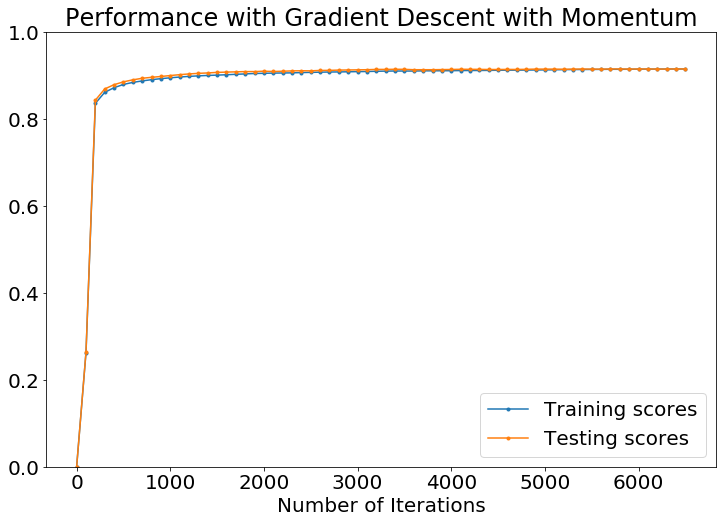

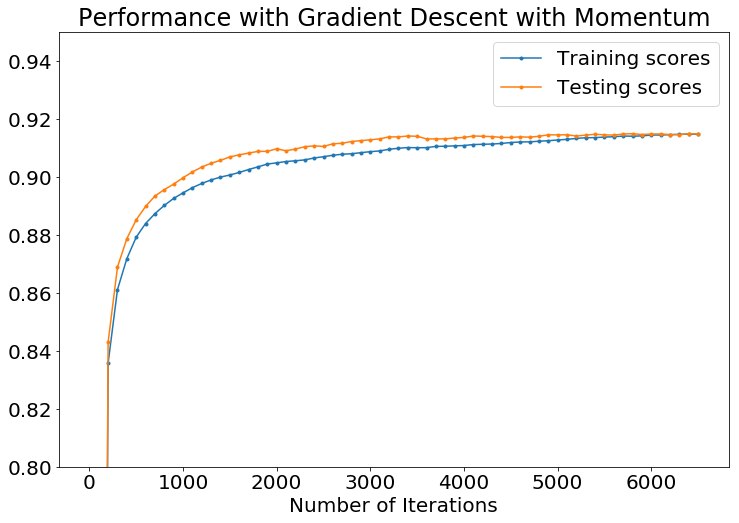

In [34]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(12 ,8))
iterations = np.arange(6500//100 +1)*100
#print(iterations)
#print(iterations.shape)
plt.plot(iterations, performance_train, label= "Training scores", marker = ".")
plt.plot(iterations, performance_test, label = "Testing scores", marker = ".")
plt.title("Performance with Gradient Descent with Momentum")
plt.xlabel("Number of Iterations")
plt.ylim([0, 1.])
plt.legend()
plt.show()

plt.figure(figsize=(12 ,8))
iterations = np.arange(6500//100 +1)*100
#print(iterations)
#print(iterations.shape)
plt.plot(iterations, performance_train, label= "Training scores", marker = ".")
plt.plot(iterations, performance_test, label = "Testing scores", marker = ".")
plt.title("Performance with Gradient Descent with Momentum")
plt.xlabel("Number of Iterations")
plt.ylim([0.8, .95])
plt.legend()
plt.show()

In [36]:
#save weights so they can be used again without rerunningn every thing
np.savetxt("final_weightspart5.txt", final_weights)

In [30]:
#part 5, gradient descent with momentum
#create a plot comparing this with vanilla gradient descent
p4_train = np.loadtxt("performance_train_p4.txt")
p4_test = np.loadtxt("performance_test_p4.txt")

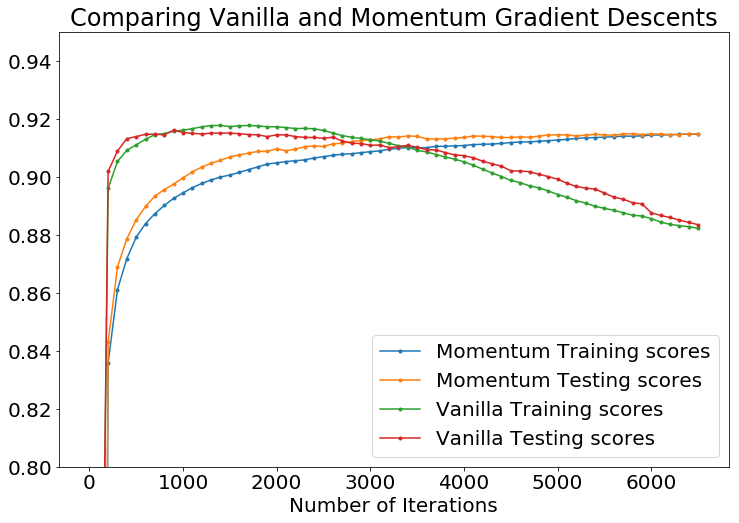

In [35]:
plt.figure(figsize=(12 ,8))
iterations = np.arange(6500//100 +1)*100
#print(iterations)
#print(iterations.shape)
plt.plot(iterations, performance_train, label= "Momentum Training scores", marker = ".")
plt.plot(iterations, performance_test, label = "Momentum Testing scores", marker = ".")
plt.plot(iterations, p4_train, label= "Vanilla Training scores", marker = ".")
plt.plot(iterations, p4_test, label = "Vanilla Testing scores", marker = ".")
plt.title("Comparing Vanilla and Momentum Gradient Descents")
plt.xlabel("Number of Iterations")
plt.ylim([0.8, .95])
plt.legend()
plt.show()